In [1]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import correlate, correlation_lags
import scipy
import mne
from nilearn import datasets, image, plotting
import scipy.io
import re
import seaborn
import pickle
import sklearn
from sklearn.mixture import GaussianMixture

# Computing Cross Correlations w/ Shuffled Audio Signal

In [2]:
id_eleccount = # Removed to protect patient anonymity

In [3]:
vis_elec = pickle.load(open("../../sourcedata/vis_elec_idx.pkl", "rb"))

In [4]:
lags = np.load("../../derivatives/results/audio-envelope/audio_lags.npy", allow_pickle=True)

### Z-Scoring Correlations

In [112]:
g1 = np.load("tr_flow_g1.npy", allow_pickle = True)
g2 = np.load("tr_flow_g2.npy", allow_pickle = True)

In [113]:
def cross_correlate(film_data, neural_data):
    xcorr_arr = np.zeros((neural_data.shape[0], film_data.shape[0] + neural_data.shape[1] - 1))
    lags_arr = np.zeros((neural_data.shape[0], film_data.shape[0] + neural_data.shape[1] - 1))
    for i in range(neural_data.shape[0]):
        xcorr_arr[i,:] = correlate(film_data - np.mean(film_data), neural_data[i, :] - np.mean(neural_data[i, :]), mode='full')
        lags_arr[i,:] = correlation_lags(film_data.shape[0], neural_data.shape[1], mode="full")
    return xcorr_arr, lags_arr

In [114]:
# Compute Z-Score for +/- 35 seconds lag around the start of the movie
def z_score_cc(cc, film_data, neural_data, electrode_num, proper_cc, spearman_lags, zero_lag_idx):
    # At every electrode and every time point, compute mean and stddev (of shuffled cc)
    shuffled_means = np.mean(cc, axis=0)
    shuffled_stdevs = np.std(cc, axis=0)
    # Z-Scored Correlations
    z_scored_cc = (proper_cc[electrode_num, :] - shuffled_means) / shuffled_stdevs
    lags_center_arr = spearman_lags[electrode_num, zero_lag_idx - 35*512:zero_lag_idx + 35*512 + 1]
    
    return z_scored_cc, lags_center_arr

In [115]:
def z_score_full(patient_id):
    nr_1 = np.load("../../sourcedata/tie-ranked-ecog/ecog1-" + patient_id + ".npy", allow_pickle = True)
    nr_2 = np.load("../../sourcedata/tie-ranked-ecog/ecog2-" + patient_id + ".npy", allow_pickle = True)

    # Proper Correlations (G1)
    spearman_cc, spearman_lags = cross_correlate(g1, nr_1)
    zero_lag_idx = np.where(spearman_lags[0, :] == 0)[0][0]
    proper_cc_1 = spearman_cc[:, zero_lag_idx - 35*512:zero_lag_idx + 35*512 + 1]
    
    # Compute Z-Score for each electrode
    for channel in vis_elec[patient_id]:
        cc_surrog = np.load("../../derivatives/results/optical-flow/TRCC/tr-cc1-" + patient_id + "-" + str(channel) + ".npy", allow_pickle = True)
        zscc_1, lags_1 = z_score_cc(cc_surrog, g1, nr_1, channel, proper_cc_1, spearman_lags, zero_lag_idx)
        np.save("../../derivatives/results/optical-flow/ZScoredCC/zscc1-" + patient_id + "-" + str(channel) + ".npy", zscc_1)
    
    zc_by_elec = np.zeros((len(vis_elec[patient_id]), 35*512*2+1))
    
    i = 0
    for channel in vis_elec[patient_id]:
        zc_by_elec[i, :] = np.load("../../derivatives/results/optical-flow/ZScoredCC/zscc1-" + patient_id + "-" + str(channel) + ".npy", allow_pickle = True)
        i += 1
    np.save("../../derivatives/results/optical-flow/av_across_elec_1_" + patient_id + ".npy", np.mean(zc_by_elec, axis=0)) 
    np.save("../../derivatives/results/optical-flow/zc_by_elec_1_" + patient_id + ".npy", zc_by_elec)  
    
    # Proper Correlations (G2)
    spearman_cc, spearman_lags = cross_correlate(g2, nr_2)
    zero_lag_idx = np.where(spearman_lags[0, :] == 0)[0][0]
    proper_cc_2 = spearman_cc[:, zero_lag_idx - 35*512:zero_lag_idx + 35*512 + 1]
    
    # Compute Z-Score for each electrode
    for channel in vis_elec[patient_id]:
        cc_surrog = np.load("../../derivatives/results/optical-flow/TRCC/tr-cc2-" + patient_id + "-" + str(channel) + ".npy", allow_pickle = True)
        zscc_2, lags_2 = z_score_cc(cc_surrog, g2, nr_2, channel, proper_cc_2, spearman_lags, zero_lag_idx)
        np.save("../../derivatives/results/optical-flow/ZScoredCC/zscc2-" + patient_id + "-" + str(channel) + ".npy", zscc_2)
    
    zc_by_elec = np.zeros((len(vis_elec[patient_id]), 35*512*2+1))
    
    i = 0
    for channel in vis_elec[patient_id]:
        zc_by_elec[i, :] = np.load("../../derivatives/results/optical-flow/ZScoredCC/zscc2-" + patient_id + "-" + str(channel) + ".npy", allow_pickle = True)
        i += 1
    np.save("../../derivatives/results/optical-flow/av_across_elec_2_" + patient_id + ".npy", np.mean(zc_by_elec, axis=0)) 
    np.save("../../derivatives/results/optical-flow/zc_by_elec_2_" + patient_id + ".npy", zc_by_elec) 

In [ ]:
for key in id_eleccount.keys():
    z_score_full(key)

# T-Test

In [1]:
# Code partially removed to protect patient anonymity

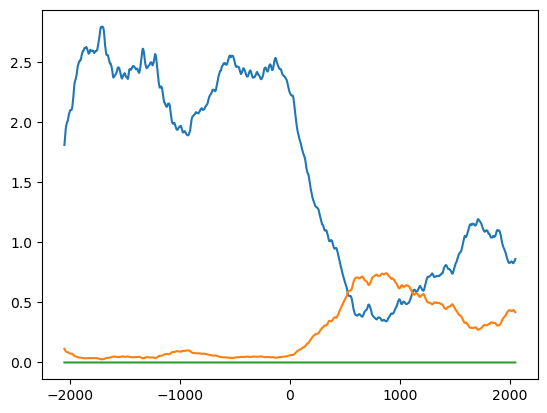

In [23]:
plt.plot(lags[15872-4*512:15872+4*512 + 1], t_vals[15872-4*512:15872+4*512 + 1])
plt.plot(lags[15872-4*512:15872+4*512 + 1], p_vals[15872-4*512:15872+4*512 + 1])
plt.plot(lags[15872-4*512:15872+4*512 + 1], np.ones(8*512+1,)*fdr_p[0])

# Plotting Significant Correlations

## Plotting Z-Scores For Significant Electrodes

In [5]:
def plot_sensitive_elec(patient_id, channel_num, pos, lag, j):
    zc_1 = np.load("../../derivatives/results/optical-flow/zc_by_elec_1_" + patient_id + ".npy", allow_pickle = True)[channel_num, 15872-4*512:15872+4*512+1]
    zc_2 = np.load("../../derivatives/results/optical-flow/zc_by_elec_2_" + patient_id + ".npy", allow_pickle = True)[channel_num, 15872-4*512:15872+4*512+1]

    fig, ax = plt.subplots()
    plt.ylim([0.5, 4])
    plt.xlabel('Time From Movie Onset (ms)')
    plt.ylabel('Z-Score')
    if pos:
        plt.plot(lags[15872-4*512:15872+4*512+1]*1000/512, (zc_1 + zc_2) / 2)
    else:
        plt.plot(lags[15872-4*512:15872+4*512+1]*-1000/512, (zc_1 + zc_2) / 2)

    plt.annotate(str(lag) + ' ms', (.6, .8), xycoords='axes fraction', fontsize=15)
    ax.hlines(y=1.65, xmin=-4000, xmax=4000, linewidth=2, color='purple', linestyle='dashed')
    fig.savefig("ZCPlots/" + patient_id + "_" + str(j) + ".png", dpi=600)
    plt.close(fig)

In [ ]:
# Determining significant electrodes: peak z-score greater than 1.65 percentile z-scores w/in 400 ms of movie onset
elecplos_list = []
lags_list = []

# Get significant electrode lag + MNI coordinate + plot
j = 0
for key in id_eleccount:
    zc_1 = np.load("../../derivatives/results/optical-flow/zc_by_elec_1_" + key + ".npy", allow_pickle = True)[:, 15872-10*512:15872+10*512+1]
    zc_2 = np.load("../../derivatives/results/optical-flow/zc_by_elec_2_" + key + ".npy", allow_pickle = True)[:, 15872-10*512:15872+10*512+1]
    elecpos = scipy.io.loadmat('/scratch/gpfs/mayaar/GravityECoG/derivatives/preprocessing/sub-ny' + key + '/eeg1_manualica_notch_elec_elecpos.mat')['trial']
    
    for i in range(len(vis_elec[key])):
        avg = (zc_1[i, :] + zc_2[i, :]) / 2
        if (np.amax(avg) > 1.65) and (np.argmax(avg) > 4600) and (np.argmax(avg) < 5400):
            lag = (np.argmax(avg)-5000) * 1000/512
            if (lag < 0):
                plot_sensitive_elec(key, i, False, abs(lag), j)
            else:
                plot_sensitive_elec(key, i, True, abs(lag), j)
            print(key, ": ", i)
            elecplos_list.append(elecpos[vis_elec[key][i], :])
            lags_list.append(lag)   
            j += 1

In [7]:
# Manually remove non-clearly responsive electrodes
indices = (1, 2, 4, 15, 16, 19, 20, 25, 27)
# 10, 12, 28
elecplos_list_filtered = [elecplos_list[i] for i in indices] 
lags_list_filtered = [abs(lags_list[i]) for i in indices]

In [8]:
lags_list_filtered

[216.796875,
 216.796875,
 119.140625,
 105.46875,
 115.234375,
 103.515625,
 107.421875,
 144.53125,
 85.9375]

In [9]:
np.mean(lags_list_filtered)

134.98263888888889

In [10]:
np.std(lags_list_filtered)

46.122471892078494

In [11]:
# Coordinates in MNI Space
og_1 = np.array([-17,-84,28])
og_2 = np.array([24,-81,31])
og_3 = np.array([-32,-81,16])
og_4 = np.array([37,-80,19])
og_5 = np.array([-36,-78,-8])
og_6 = np.array([38,-82,-8])

cal_1 = np.array([-7,-79,6])
cal_2 = np.array([16,-73,9])

vis_full = [cal_1, cal_2]

def calc_dist_from_occip(coord):
    dists = []
    
    for posit in vis_full:
        dists.append(np.linalg.norm(posit - coord))
        
    return min(dists)

In [12]:
dists = []

for pos in elecplos_list_filtered:
    dists.append(calc_dist_from_occip(pos))

In [13]:
dists

[66.37770710110436,
 67.74953874381728,
 78.8638066542568,
 48.828520126868476,
 65.64815305855909,
 29.8496231131986,
 40.45024570728835,
 29.175681273622384,
 29.028262090590264]

In [14]:
np.mean(dists)

50.663504207700626

In [15]:
np.std(dists)

18.346574630058363

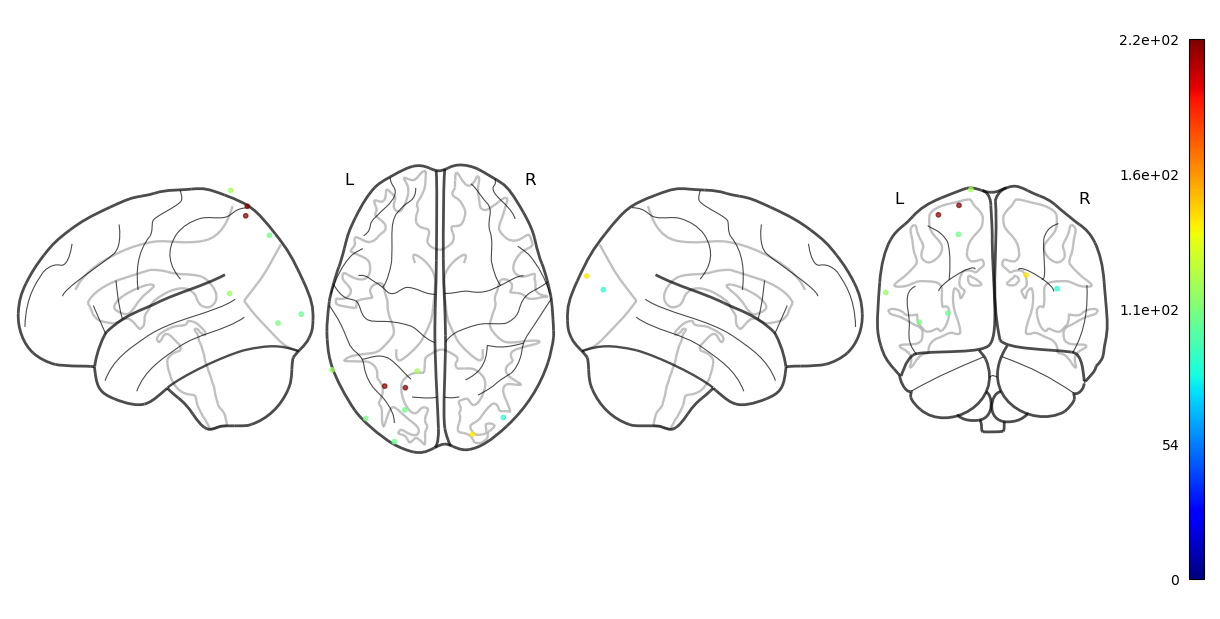

In [16]:
fig = plt.figure(figsize=(12, 6))
plotting.plot_markers(lags_list_filtered,
                elecplos_list_filtered,
                node_size=10,
                node_vmin=0,
                node_vmax=np.max(lags_list_filtered),
                node_cmap=plt.cm.jet,
                node_threshold=None,
                display_mode='lzry',
                figure=fig,
                axes=None,
                title=None,
                annotate=True,
                colorbar=True)
plt.savefig("flow_zc.png", dpi=600)